# Processing Sequences Using RNNs and CNNs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl

In [38]:
from tensorflow.keras import models, layers, optimizers, losses, metrics, activations
import tensorflow as tf

# Basic RNNs

### Generate the Dataset

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [4]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
X_train.shape, y_train.shape

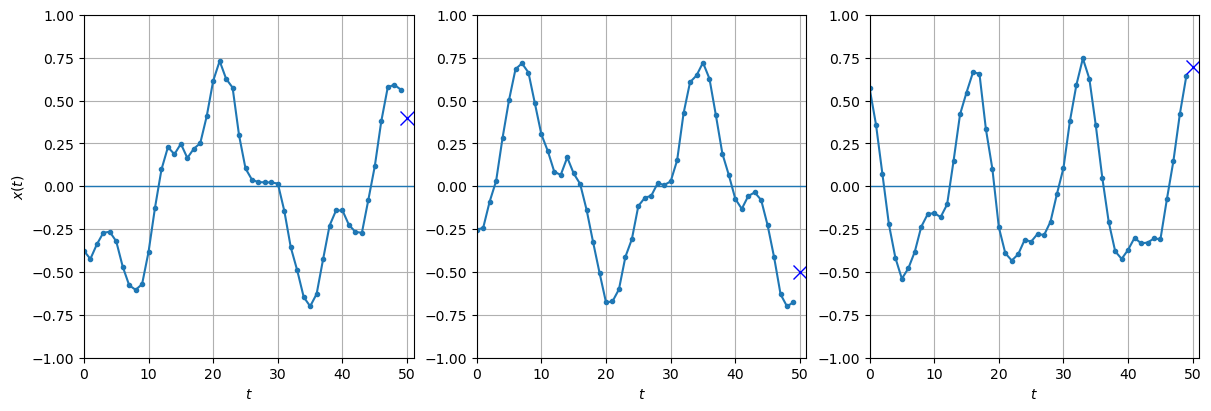

In [6]:
def plot_series(ax,
                series,
                y=None,
                y_pred=None,
                x_label="$t$",
                y_label="$x(t)$"):

    ax.plot(series, ".-")
    if y is not None:
        ax.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        ax.plot(n_steps, y_pred, "ro")
    ax.grid(1)
    if x_label:
        ax.set(xlabel=x_label)
    if y_label:
        ax.set(ylabel=y_label)
    ax.hlines(0, 0, 100, lw=1)
    ax.axis([0, n_steps + 1, -1, 1])

_, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=100, constrained_layout=True)

for col, ax in enumerate(axes.flatten()):
    plot_series(ax,
                X_valid[col, :, 0],
                y_valid[col, 0],
                y_label=("$x(t)$" if col == 0 else None))

plt.show()

### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [7]:
y_pred = X_valid[:, -1]
Y_pred.shape

2021-09-23 14:16:14.967235: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.020211367

In [ ]:
np.mean(losses.mean_squared_error(y_valid, y_pred))

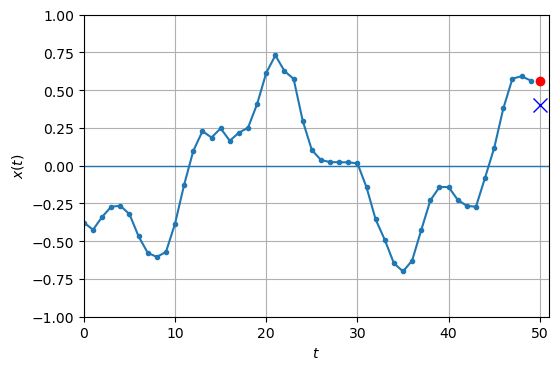

In [8]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

plot_series(ax, X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

model = models.Sequential([
    layers.Flatten(input_shape=[50, 1]),
    layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

2021-09-23 14:16:17.721866: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/20
219/219 [==============================] - 10s 31ms/step - loss: 0.1398 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0443 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0237 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0142 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0110 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0064 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0063 - val_loss: 0.00

In [10]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0042


0.004168087150901556

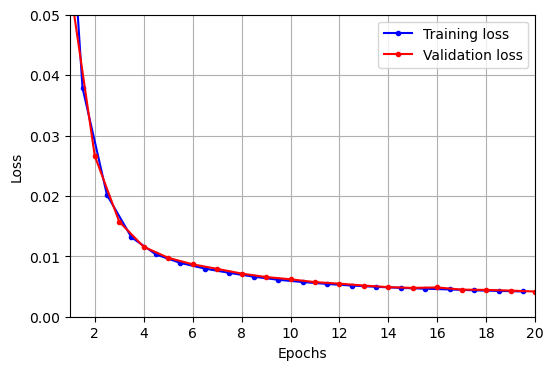

In [ ]:
def plot_learning_curves(ax):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    ax.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    ax.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    ax.axis([1, 20, 0, 0.05])
    ax.set(xlabel="Epochs", ylabel="Loss")
    ax.grid(1)
    ax.legend()


_, ax = plt.subplots(figsize=(6, 4), dpi=100)

plot_learning_curves(ax)
plt.show()

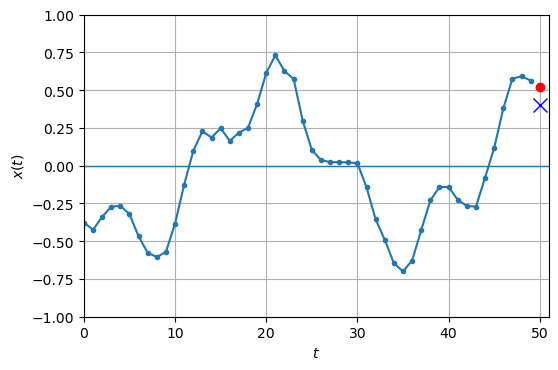

In [12]:
y_pred = model.predict(X_valid)

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

plot_series(ax, X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

model = models.Sequential([
    layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 9s 26ms/step - loss: 0.1554 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0409 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0277 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0208 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0174 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0138 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0128 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0117 - val_lo

In [14]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0109


0.010881561785936356

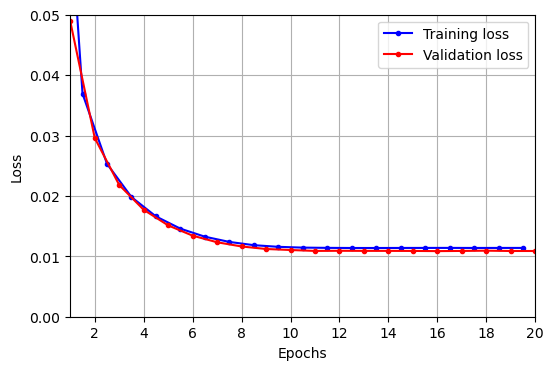

In [16]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

plot_learning_curves(ax)
plt.show()

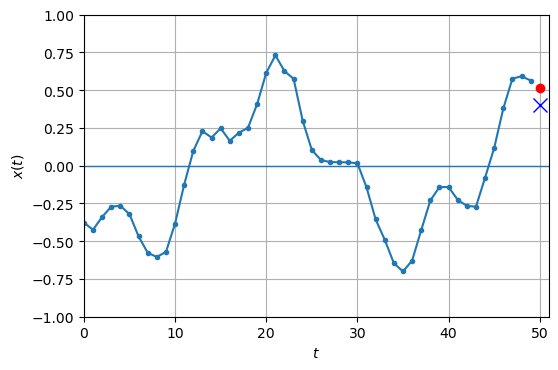

In [18]:
y_pred = model.predict(X_valid)

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

plot_series(ax, X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = models.Sequential([
    layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    layers.SimpleRNN(20, return_sequences=True),
    layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 23s 61ms/step - loss: 0.1324 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 12s 55ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 14s 62ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 13s 57ms/step - loss: 0.003

In [21]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 14ms/step - loss: 0.0029


0.002910564886406064

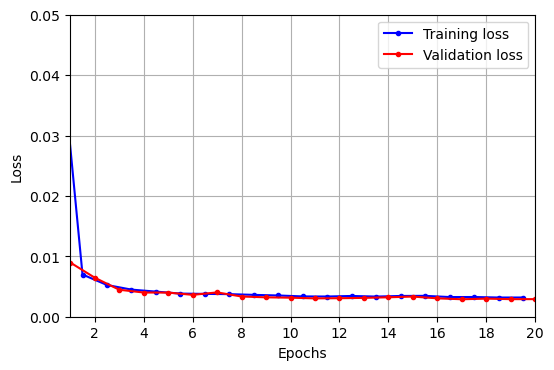

In [22]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

plot_learning_curves(ax)
plt.show()

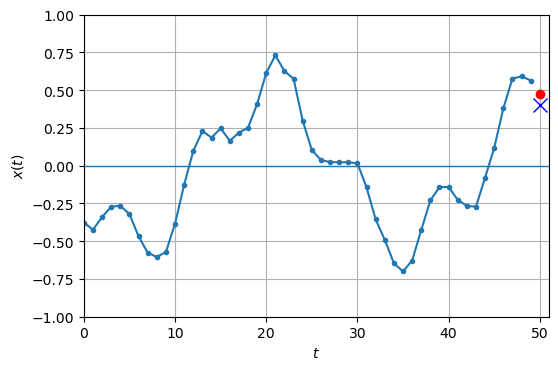

In [23]:
y_pred = model.predict(X_valid)

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

plot_series(ax, X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Make the second `SimpleRNN` layer return only the last output:

In [24]:
np.random.seed(42)
tf.random.set_seed(42)

model = models.Sequential([
    layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    layers.SimpleRNN(20),
    layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 16s 49ms/step - loss: 0.0566 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 9s 42ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0029 - va

In [25]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0026


0.0026236234698444605

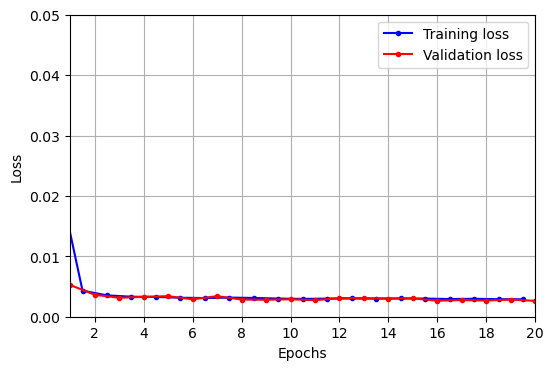

In [26]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

plot_learning_curves(ax)
plt.show()

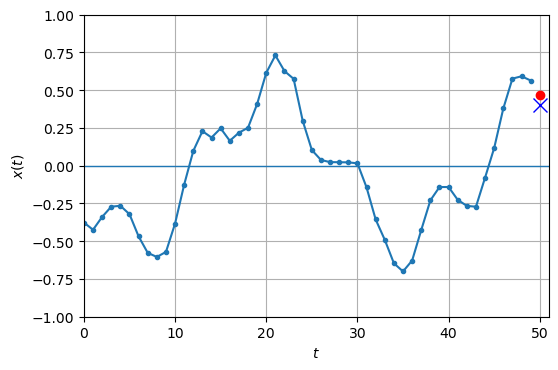

In [27]:
y_pred = model.predict(X_valid)

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

plot_series(ax, X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [28]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]
Y_pred.shape

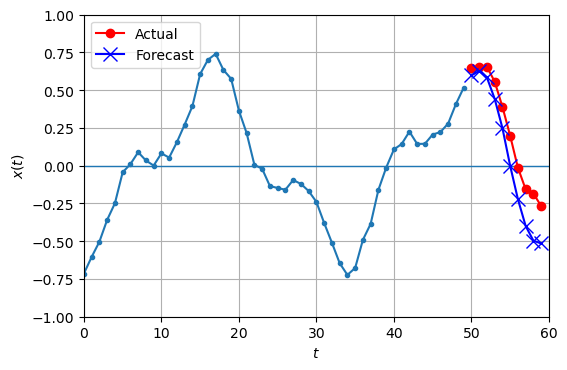

In [33]:
def plot_multiple_forecasts(ax, X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(ax, X[0, :, 0])
    ax.plot(np.arange(n_steps, n_steps + ahead),
            Y[0, :, 0],
            "ro-",
            label="Actual")
    ax.plot(np.arange(n_steps, n_steps + ahead),
            Y_pred[0, :, 0],
            "bx-",
            label="Forecast",
            markersize=10)
    ax.axis([0, n_steps + ahead, -1, 1])
    ax.legend(fontsize='medium')

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

plot_multiple_forecasts(ax, X_new, Y_new, Y_pred)
plt.show()

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [34]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [35]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]
Y_pred.shape

In [39]:
np.mean(metrics.mean_squared_error(Y_valid, Y_pred))

0.027510861

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [40]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
np.mean(metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model = models.Sequential([
    layers.Flatten(input_shape=[50, 1]),
    layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 6ms/step - loss: 0.2186 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0535 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0406 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0343 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0300 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0278 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0262 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0236 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0228 - val_loss: 0.0222

Now let's create an RNN that predicts all 10 next values at once:

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

model = models.Sequential([
    layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    layers.SimpleRNN(20),
    layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train,
                    Y_train,
                    epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 12s 40ms/step - loss: 0.1216 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0294 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0198 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0162 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 8s 34ms/step - loss: 0.0144 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0127 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0118 - val_l

In [43]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

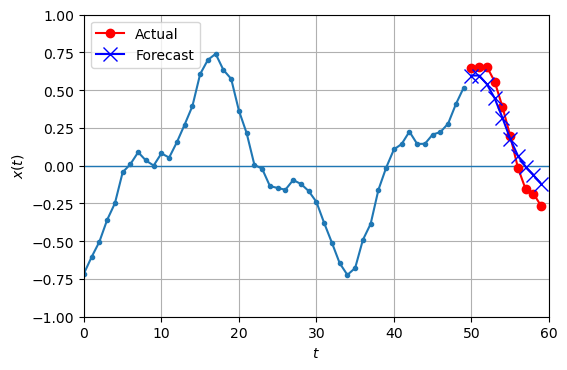

In [44]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

plot_multiple_forecasts(ax, X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [45]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))

for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [46]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

model = models.Sequential([
    layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    layers.SimpleRNN(20, return_sequences=True),
    layers.TimeDistributed(layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpnbo1ychw.py, line 12)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpnbo1ychw.py, line 12)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
219/219 [==============================] - 15s 49ms/step - loss: 0.0705 - last_time_step_mse: 0.0621 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0413 - last_time_step_mse: 0.0301 - val_loss: 0.0366 - val_last_time_step_mse: 0.0265
Epoch 3/20
219/219 [==============================] - 8s 39ms/step - 

In [48]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

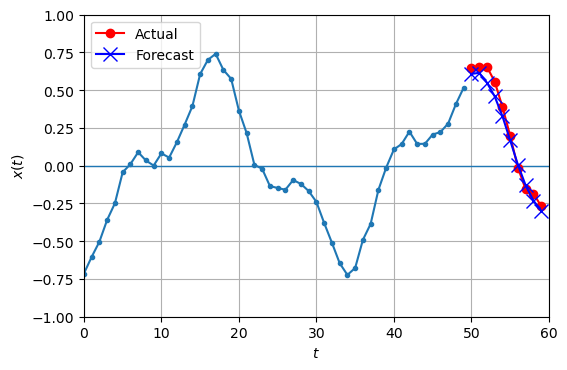

In [49]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

plot_multiple_forecasts(ax, X_new, Y_new, Y_pred)
plt.show()

# Deep RNN with Batch Norm

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

model = models.Sequential([
    layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    layers.BatchNormalization(),
    layers.SimpleRNN(20, return_sequences=True),
    layers.BatchNormalization(),
    layers.TimeDistributed(layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 11s 38ms/step - loss: 0.4750 - last_time_step_mse: 0.5027 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0561 - last_time_step_mse: 0.0468 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0486 - last_time_step_mse: 0.0394 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0443 - last_time_step_mse: 0.0344 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0414 - last_time_step_mse: 0.0315 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0391 - last_time_step_mse: 0.0281 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20
219/219 [

# Deep RNNs with Layer Norm

In [51]:
class LNSimpleRNNCell(layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = layers.LayerNormalization()
        self.activation = activations.get(activation)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [52]:
np.random.seed(42)
tf.random.set_seed(42)

model = models.Sequential([
    layers.RNN(LNSimpleRNNCell(20),
               return_sequences=True,
               input_shape=[None, 1]),
    layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    layers.TimeDistributed(layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train,
                    Y_train,
                    epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 23s 69ms/step - loss: 0.2856 - last_time_step_mse: 0.2823 - val_loss: 0.0760 - val_last_time_step_mse: 0.0652
Epoch 2/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0701 - last_time_step_mse: 0.0577 - val_loss: 0.0588 - val_last_time_step_mse: 0.0463
Epoch 3/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0571 - last_time_step_mse: 0.0449 - val_loss: 0.0516 - val_last_time_step_mse: 0.0359
Epoch 4/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0503 - last_time_step_mse: 0.0358 - val_loss: 0.0462 - val_last_time_step_mse: 0.0301
Epoch 5/20
219/219 [==============================] - 15s 69ms/step - loss: 0.0454 - last_time_step_mse: 0.0304 - val_loss: 0.0429 - val_last_time_step_mse: 0.0269
Epoch 6/20
219/219 [==============================] - 15s 69ms/step - loss: 0.0424 - last_time_step_mse: 0.0277 - val_loss: 0.0395 - val_last_time_step_mse: 0.0250
Epoch 7/20
219/2

# Creating a Custom RNN Class

In [57]:
class MyRNN(layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(self.cell, "get_initial_state",
                                         self.fallback_initial_state)

    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [
            tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)
        ]

    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        batch_size = tf.shape(inputs)[0]
        n_steps = tf.shape(inputs)[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size],
                           dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [58]:
np.random.seed(42)
tf.random.set_seed(42)

model = models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    layers.TimeDistributed(layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train,
                    Y_train,
                    epochs=20,
                    validation_data=(X_valid, Y_valid))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmphd25uqca.py, line 26)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmphd25uqca.py, line 26)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


OperatorNotAllowedInGraphError: iterating over `tf.Tensor` is not allowed: AutoGraph did convert this function. This might indicate you are trying to use an unsupported feature.

# LSTMs

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

model = models.Sequential([
    layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    layers.LSTM(20, return_sequences=True),
    layers.TimeDistributed(layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 33s 79ms/step - loss: 0.0979 - last_time_step_mse: 0.0877 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0515 - last_time_step_mse: 0.0326 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 16s 71ms/step - loss: 0.0407 - last_time_step_mse: 0.0196 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 13s 59ms/step - loss: 0.0356 - last_time_step_mse: 0.0156 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 17s 79ms/step - loss: 0.0330 - last_time_step_mse: 0.0138 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 17s 80ms/step - loss: 0.0313 - last_time_step_mse: 0.0124 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/2

In [ ]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 0s 234us/sample - loss: 0.0240 - last_time_step_mse: 0.0086


[0.024016654595732687, 0.00855141]

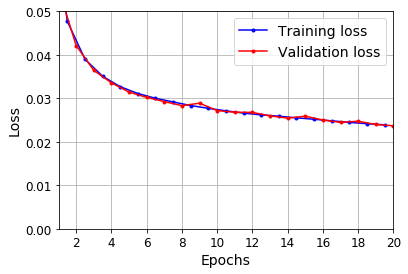

In [ ]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

plot_learning_curves(ax)
plt.show()

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

plot_multiple_forecasts(ax, X_new, Y_new, Y_pred)
plt.show()

# GRUs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = models.Sequential([
    layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    layers.GRU(20, return_sequences=True),
    layers.TimeDistributed(layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0742 - last_time_step_mse: 0.0663 - val_loss: 0.0523 - val_last_time_step_mse: 0.0421
Epoch 2/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0327
Epoch 3/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0418 - last_time_step_mse: 0.0305 - val_loss: 0.0391 - val_last_time_step_mse: 0.0271
Epoch 4/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0373 - last_time_step_mse: 0.0249 - val_loss: 0.0343 - val_last_time_step_mse: 0.0205
Epoch 5/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0327 - last_time_step_mse: 0.0179 - val_loss: 0.0313 - val_last_time_step_mse: 0.0158
Epoch 6/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0308 - last_time_step_mse: 0.0155 - val_l

In [ ]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 0s 201us/sample - loss: 0.0241 - last_time_step_mse: 0.0103


[0.02407100349664688, 0.010298318]

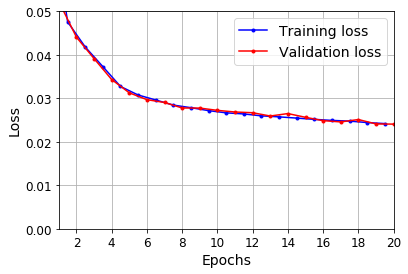

In [ ]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

plot_learning_curves(ax)
plt.show()

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

plot_multiple_forecasts(ax, X_new, Y_new, Y_pred)
plt.show()

## Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = models.Sequential([
    layers.Conv1D(filters=20,
                  kernel_size=4,
                  strides=2,
                  padding="valid",
                  input_shape=[None, 1]),
    layers.GRU(20, return_sequences=True),
    layers.GRU(20, return_sequences=True),
    layers.TimeDistributed(layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train,
                    Y_train[:, 3::2],
                    epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 7s 938us/sample - loss: 0.0683 - last_time_step_mse: 0.0605 - val_loss: 0.0482 - val_last_time_step_mse: 0.0405
Epoch 2/20
7000/7000 [==============================] - 4s 630us/sample - loss: 0.0416 - last_time_step_mse: 0.0342 - val_loss: 0.0368 - val_last_time_step_mse: 0.0283
Epoch 3/20
7000/7000 [==============================] - 5s 670us/sample - loss: 0.0334 - last_time_step_mse: 0.0251 - val_loss: 0.0307 - val_last_time_step_mse: 0.0220
Epoch 4/20
7000/7000 [==============================] - 5s 651us/sample - loss: 0.0273 - last_time_step_mse: 0.0172 - val_loss: 0.0251 - val_last_time_step_mse: 0.0141
Epoch 5/20
7000/7000 [==============================] - 4s 639us/sample - loss: 0.0243 - last_time_step_mse: 0.0134 - val_loss: 0.0238 - val_last_time_step_mse: 0.0128
Epoch 6/20
7000/7000 [==============================] - 4s 639us/sample - loss: 0.0230 - last_time_step_mse: 0.0

## WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = models.Sequential()
model.add(layers.InputLayer(input_shape=[None, 1]))

for rate in (1, 2, 4, 8) * 2:
    model.add(
        layers.Conv1D(filters=20,
                      kernel_size=2,
                      padding="causal",
                      activation="relu",
                      dilation_rate=rate))

model.add(layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train,
                    Y_train,
                    epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 2s 275us/sample - loss: 0.0684 - last_time_step_mse: 0.0550 - val_loss: 0.0387 - val_last_time_step_mse: 0.0248
Epoch 2/20
7000/7000 [==============================] - 1s 176us/sample - loss: 0.0342 - last_time_step_mse: 0.0216 - val_loss: 0.0307 - val_last_time_step_mse: 0.0182
Epoch 3/20
7000/7000 [==============================] - 1s 194us/sample - loss: 0.0293 - last_time_step_mse: 0.0172 - val_loss: 0.0275 - val_last_time_step_mse: 0.0152
Epoch 4/20
7000/7000 [==============================] - 1s 186us/sample - loss: 0.0270 - last_time_step_mse: 0.0149 - val_loss: 0.0259 - val_last_time_step_mse: 0.0140
Epoch 5/20
7000/7000 [==============================] - 1s 182us/sample - loss: 0.0254 - last_time_step_mse: 0.0133 - val_loss: 0.0248 - val_last_time_step_mse: 0.0126
Epoch 6/20
7000/7000 [==============================] - 1s 182us/sample - loss: 0.0245 - last_time_step_mse: 0.0

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [ ]:
class GatedActivationUnit(layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [ ]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = layers.Conv1D(2 * n_filters,
                      kernel_size=2,
                      padding="causal",
                      dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = layers.Conv1D(n_filters, kernel_size=1)(z)
    return layers.Add()([z, inputs]), z

In [ ]:
backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 10  # 256 in the paper

inputs = layers.Input(shape=[None, 1])
z = layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []

for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = activations.relu(layers.Add()(skip_to_last))
z = layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = models.Model(inputs=[inputs], outputs=[Y_proba])

In [ ]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/2
7000/7000 [==============================] - 3s 443us/sample - loss: 0.1299 - last_time_step_mse: 0.1258 - val_loss: 0.1229 - val_last_time_step_mse: 0.1199
Epoch 2/2
7000/7000 [==============================] - 2s 271us/sample - loss: 0.1222 - last_time_step_mse: 0.1178 - val_loss: 0.1218 - val_last_time_step_mse: 0.1190


In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs. In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders). We will also look at the Transformer, an Attention-only architecture.

# Exercise solutions

## 9. Tackling the SketchRNN Dataset

_Exercise: Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets._

The dataset is not available in TFDS yet, the [pull request](https://github.com/tensorflow/datasets/pull/361) is still work in progress. Luckily, the data is conveniently available as TFRecords, so let's download it (it might take a while, as it's about 1 GB large, with 3,450,000 training sketches and 345,000 test sketches):

In [ ]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

In [ ]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [ ]:
train_files

['/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010']

In [ ]:
eval_files

['/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00000-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00001-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00002-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00003-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00004-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00005-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00006-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00007-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00008-of-00010',
 '/Users/ageron/.keras/datasets/quickdraw/eval.tfrecord-00009-of-00010']

In [ ]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [ ]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [ ]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [ ]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [ ]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [ ]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [ ]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.07058823  0.04255319  0.        ]
  [-0.01568627  0.0425532   0.        ]
  [-0.09803921  0.03191489  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.07058824  0.27741933  0.        ]
  [-0.02745098  0.06451613  0.        ]
  [-0.02352941  0.          0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.17857143  0.06666667  0.        ]
  [-0.26020408  0.15294117  0.        ]
  [-0.01020408  0.01568627  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.03056769 -0.01176471  0.        ]
  [ 0.29694325  0.          0.        ]
  [ 0.38864627  0.04705882  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

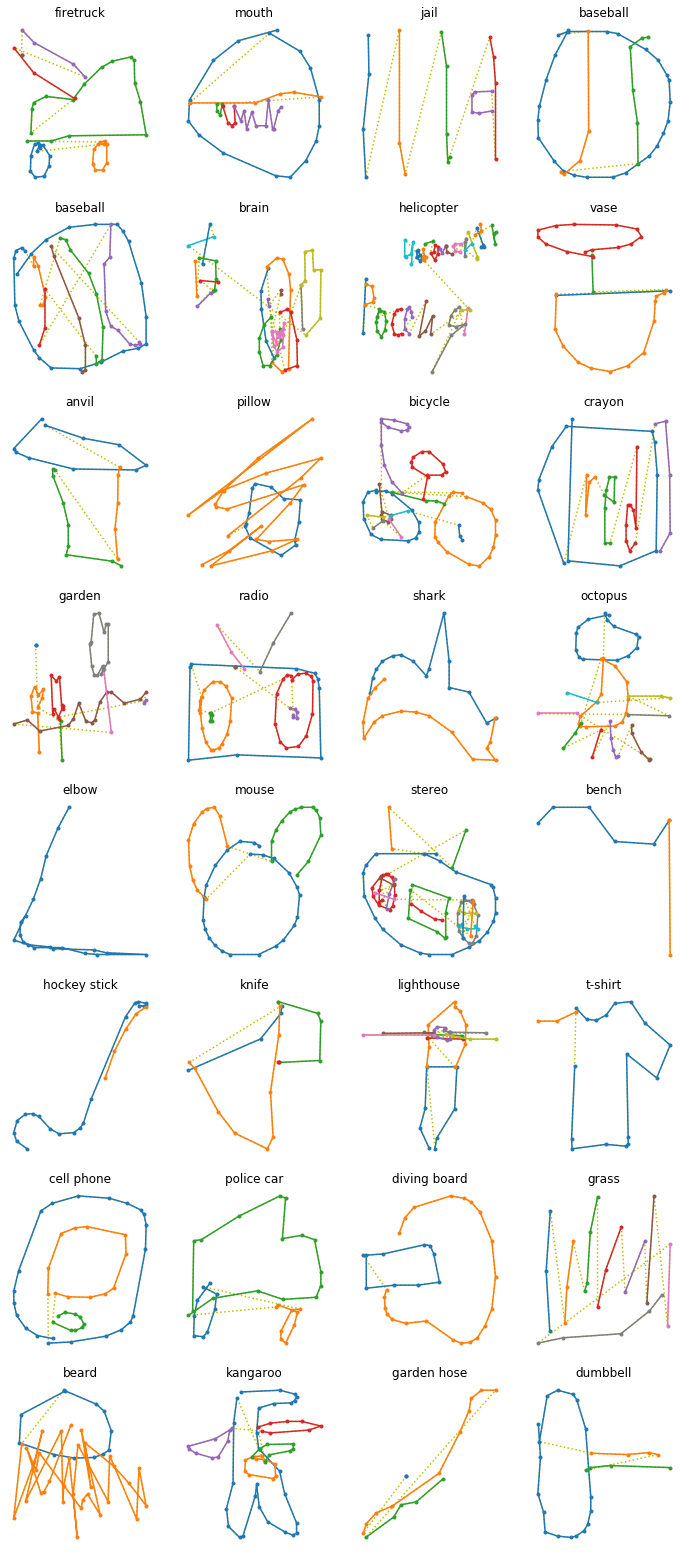

In [ ]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    ax.set(title=title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

Most sketches are composed of less than 100 points:

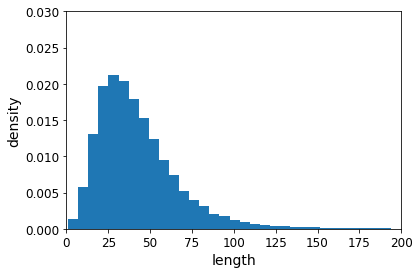

In [ ]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
ax.set(xlim=[0, 200, 0, 0.03])
ax.set(xlabel="length")
ax.set(ylabel="density")
plt.show()

In [ ]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 2182s 20ms/step - loss: 3.8473 - accuracy: 0.2086 - sparse_top_k_categorical_accuracy: 0.4242 - val_loss: 2.6672 - val_accuracy: 0.3872 - val_sparse_top_k_categorical_accuracy: 0.6771
Epoch 2/2
107813/107813 [==============================] - 2049s 19ms/step - loss: 2.3393 - accuracy: 0.4502 - sparse_top_k_categorical_accuracy: 0.7367 - val_loss: 2.1072 - val_accuracy: 0.4968 - val_sparse_top_k_categorical_accuracy: 0.7759


In [ ]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [ ]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.6899671

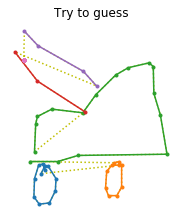

Top-5 predictions:
  1. firetruck 46.565%
  2. police car 30.455%
  3. ambulance 3.810%
  4. car 3.695%
  5. cannon 3.371%
Answer: firetruck


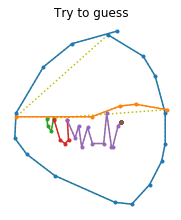

Top-5 predictions:
  1. mouth 23.162%
  2. pond 14.151%
  3. pool 12.582%
  4. beard 11.375%
  5. goatee 9.808%
Answer: mouth


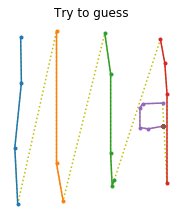

Top-5 predictions:
  1. jail 71.532%
  2. fence 6.519%
  3. swing set 5.708%
  4. grass 3.302%
  5. rain 3.023%
Answer: jail


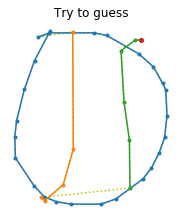

Top-5 predictions:
  1. baseball 79.233%
  2. watermelon 7.687%
  3. basketball 5.259%
  4. clock 1.659%
  5. compass 1.101%
Answer: baseball


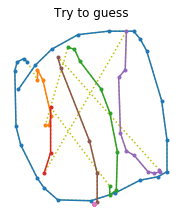

Top-5 predictions:
  1. basketball 51.888%
  2. baseball 17.328%
  3. onion 12.688%
  4. watermelon 9.989%
  5. brain 2.216%
Answer: baseball


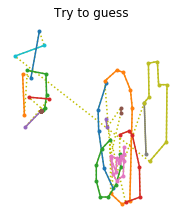

Top-5 predictions:
  1. lantern 7.235%
  2. toothpaste 6.845%
  3. drill 6.254%
  4. lighthouse 4.624%
  5. crayon 3.566%
Answer: brain


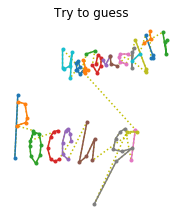

Top-5 predictions:
  1. animal migration 8.771%
  2. blackberry 7.932%
  3. blueberry 6.413%
  4. peas 5.549%
  5. bracelet 3.623%
Answer: helicopter


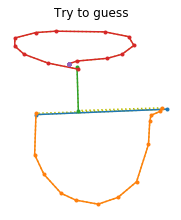

Top-5 predictions:
  1. vase 42.793%
  2. wine glass 13.744%
  3. shovel 8.136%
  4. house plant 5.144%
  5. sailboat 4.850%
Answer: vase


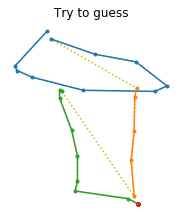

Top-5 predictions:
  1. anvil 25.870%
  2. drill 9.670%
  3. nail 7.246%
  4. screwdriver 5.611%
  5. knee 4.355%
Answer: anvil


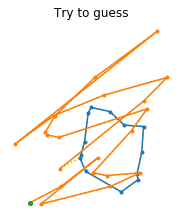

Top-5 predictions:
  1. hurricane 34.674%
  2. tornado 16.056%
  3. blackberry 7.664%
  4. squiggle 5.489%
  5. zigzag 4.906%
Answer: pillow


In [ ]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [ ]:
model.save("my_sketchrnn")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_sketchrnn/assets


## 10. Bach Chorales
_Exercise: Download the [Bach chorales](https://homl.info/bach) dataset and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note's index on a piano (except for the value 0, which means that no note is played). Train a model—recurrent, convolutional, or both—that can predict the next time step (four notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on. Also make sure to check out [Google's Coconet model](https://homl.info/coconet), which was used for a nice [Google doodle about Bach](https://www.google.com/doodles/celebrating-johann-sebastian-bach)._



In [ ]:
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/datasets/jsb_chorales/"
FILENAME = "jsb_chorales.tgz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/jsb_chorales",
                                extract=True)

In [ ]:
jsb_chorales_dir = Path(filepath).parent
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [ ]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [ ]:
train_chorales[0]

[[74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [75, 70, 58, 55],
 [75, 70, 58, 55],
 [75, 70, 60, 55],
 [75, 70, 60, 55],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 70, 62, 55],
 [77, 70, 62, 55],
 [77, 69, 62, 55],
 [77, 69, 62, 55],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [77, 65, 62, 50],
 [77, 65, 62, 50],
 [77, 65, 60, 50],
 [77, 65, 60, 50],
 [74, 67, 58, 55],
 [74, 67, 58, 55],
 [74, 67, 58, 53],
 [74, 67, 58, 53],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 65, 57

Notes range from 36 (C1 = C on octave 1) to 81 (A5 = A on octave 5), plus 0 for silence:

In [ ]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

assert min_note == 36
assert max_note == 81

Let's write a few functions to listen to these chorales (you don't need to understand the details here, and in fact there are certainly simpler ways to do this, for example using MIDI players, but I just wanted to have a bit of fun writing a synthesizer):

In [ ]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # Frequency doubles when you go up one octave; there are 12 semi-tones
    # per octave; Note A on octave 4 is 440 Hz, and it is note number 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # the tempo is measured in beats per minutes
    # To reduce click sound at every beat, we round the frequencies to try to
    # get the samples close to zero at the end of each note.
    frequencies = np.round(note_duration * frequencies) / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removing all notes with frequencies ≤ 9 Hz (includes note 0 = silence)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # make last note a bit longer
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # fade out last note
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

Now let's listen to a few chorales:

In [ ]:
for index in range(3):
    play_chords(train_chorales[index])

Divine! :)

In order to be able to generate new chorales, we want to train a model that can predict the next chord given all the previous chords. If we naively try to predict the next chord in one shot, predicting all 4 notes at once, we run the risk of getting notes that don't go very well together (believe me, I tried). It's much better and simpler to predict one note at a time. So we will need to preprocess every chorale, turning each chord into an arpegio (i.e., a sequence of notes rather than notes played simultaneuously). So each chorale will be a long sequence of notes (rather than chords), and we can just train a model that can predict the next note given all the previous notes. We will use a sequence-to-sequence approach, where we feed a window to the neural net, and it tries to predict that same window shifted one time step into the future.

We will also shift the values so that they range from 0 to 46, where 0 represents silence, and values 1 to 46 represent notes 36 (C1) to 81 (A5).

And we will train the model on windows of 128 notes (i.e., 32 chords).

Since the dataset fits in memory, we could preprocess the chorales in RAM using any Python code we like, but I will demonstrate here how to do all the preprocessing using tf.data (there will be more details about creating windows using tf.data in the next chapter).

In [ ]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # predict next note in each arpegio, at each step
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # shift values
    return tf.reshape(window, [-1]) # convert to arpegio

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

Now let's create the training set, the validation set and the test set:

In [ ]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

Now let's create the model:

* We could feed the note values directly to the model, as floats, but this would probably not give good results. Indeed, the relationships between notes are not that simple: for example, if you replace a C3 with a C4, the melody will still sound fine, even though these notes are 12 semi-tones apart (i.e., one octave). Conversely, if you replace a C3 with a C\#3, it's very likely that the chord will sound horrible, despite these notes being just next to each other. So we will use an `Embedding` layer to convert each note to a small vector representation (see Chapter 16 for more details on embeddings). We will use 5-dimensional embeddings, so the output of this first layer will have a shape of `[batch_size, window_size, 5]`.
* We will then feed this data to a small WaveNet-like neural network, composed of a stack of 4 `Conv1D` layers with doubling dilation rates. We will intersperse these layers with `BatchNormalization` layers for faster better convergence.
* Then one `LSTM` layer to try to capture long-term patterns.
* And finally a `Dense` layer to produce the final note probabilities. It will predict one probability for each chorale in the batch, for each time step, and for each possible note (including silence). So the output shape will be `[batch_size, window_size, 47]`.

In [ ]:
n_embedding_dims = 5

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.Dense(n_notes, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 5)           235       
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          352       
_________________________________________________________________
batch_normalization (BatchNo (None, None, 32)          128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 48)          3120      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 48)          192       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          6208      
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 64)          2

Now we're ready to compile and train the model!

In [ ]:
optimizer = keras.optimizers.Nadam(lr=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.fit(train_set, epochs=20, validation_data=valid_set)

Epoch 1/20
98/98 [==============================] - 17s 171ms/step - loss: 1.8198 - accuracy: 0.5358 - val_loss: 3.7675 - val_accuracy: 0.0428
Epoch 2/20
98/98 [==============================] - 15s 152ms/step - loss: 0.8885 - accuracy: 0.7641 - val_loss: 4.1054 - val_accuracy: 0.0470
Epoch 3/20
98/98 [==============================] - 16s 165ms/step - loss: 0.7471 - accuracy: 0.7930 - val_loss: 3.8600 - val_accuracy: 0.0368
Epoch 4/20
98/98 [==============================] - 16s 165ms/step - loss: 0.6749 - accuracy: 0.8083 - val_loss: 3.0490 - val_accuracy: 0.2196
Epoch 5/20
98/98 [==============================] - 15s 157ms/step - loss: 0.6221 - accuracy: 0.8188 - val_loss: 1.7138 - val_accuracy: 0.5153
Epoch 6/20
98/98 [==============================] - 16s 163ms/step - loss: 0.5833 - accuracy: 0.8283 - val_loss: 1.9068 - val_accuracy: 0.4570
Epoch 7/20
98/98 [==============================] - 16s 165ms/step - loss: 0.5484 - accuracy: 0.8362 - val_loss: 0.7930 - val_accuracy: 0.7678

I have not done much hyperparameter search, so feel free to iterate on this model now and try to optimize it. For example, you could try removing the `LSTM` layer and replacing it with `Conv1D` layers. You could also play with the number of layers, the learning rate, the optimizer, and so on.

Once you're satisfied with the performance of the model on the validation set, you can save it and evaluate it one last time on the test set:

In [ ]:
model.save("my_bach_model.h5")
model.evaluate(test_set)

     34/Unknown - 2s 66ms/step - loss: 0.6557 - accuracy: 0.8164

[0.6556663916391485, 0.8164004]

**Note:** There's no real need for a test set in this exercise, since we will perform the final evaluation by just listening to the music produced by the model. So if you want, you can add the test set to the train set, and train the model again, hopefully getting a slightly better model.

Now let's write a function that will generate a new chorale. We will give it a few seed chords, it will convert them to arpegios (the format expected by the model), and use the model to predict the next note, then the next, and so on. In the end, it will group the notes 4 by 4 to create chords again, and return the resulting chorale.

**Warning**: `model.predict_classes(X)` is deprecated. It is replaced with `np.argmax(model.predict(X), axis=-1)`.

In [ ]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            #next_note = model.predict_classes(arpegio)[:1, -1:]
            next_note = np.argmax(model.predict(arpegio), axis=-1)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

To test this function, we need some seed chords. Let's use the first 8 chords of one of the test chorales (it's actually just 2 different chords, each played 4 times):

In [ ]:
seed_chords = test_chorales[2][:8]
play_chords(seed_chords, amplitude=0.2)

Now we are ready to generate our first chorale! Let's ask the function to generate 56 more chords, for a total of 64 chords, i.e., 16 bars (assuming 4 chords per bar, i.e., a 4/4 signature):

In [ ]:
new_chorale = generate_chorale(model, seed_chords, 56)
play_chords(new_chorale)

This approach has one major flaw: it is often too conservative. Indeed, the model will not take any risk, it will always choose the note with the highest score, and since repeating the previous note generally sounds good enough, it's the least risky option, so the algorithm will tend to make notes last longer and longer. Pretty boring. Plus, if you run the model multiple times, it will always generate the same melody.

So let's spice things up a bit! Instead of always picking the note with the highest score, we will pick the next note randomly, according to the predicted probabilities. For example, if the model predicts a C3 with 75% probability, and a G3 with a 25% probability, then we will pick one of these two notes randomly, with these probabilities. We will also add a `temperature` parameter that will control how "hot" (i.e., daring) we want the system to feel. A high temperature will bring the predicted probabilities closer together, reducing the probability of the likely notes and increasing the probability of the unlikely ones.

In [ ]:
def generate_chorale_v2(model, seed_chords, length, temperature=1):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note_probas = model.predict(arpegio)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / temperature
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

Let's generate 3 chorales using this new function: one cold, one medium, and one hot (feel free to experiment with other seeds, lengths and temperatures). The code saves each chorale to a separate file. You can run these cells over an over again until you generate a masterpiece!

**Please share your most beautiful generated chorale with me on Twitter @aureliengeron, I would really appreciate it! :))**

In [ ]:
new_chorale_v2_cold = generate_chorale_v2(model, seed_chords, 56, temperature=0.8)
play_chords(new_chorale_v2_cold, filepath="bach_cold.wav")

In [ ]:
new_chorale_v2_medium = generate_chorale_v2(model, seed_chords, 56, temperature=1.0)
play_chords(new_chorale_v2_medium, filepath="bach_medium.wav")

In [ ]:
new_chorale_v2_hot = generate_chorale_v2(model, seed_chords, 56, temperature=1.5)
play_chords(new_chorale_v2_hot, filepath="bach_hot.wav")

Lastly, you can try a fun social experiment: send your friends a few of your favorite generated chorales, plus the real chorale, and ask them to guess which one is the real one!

In [ ]:
play_chords(test_chorales[2][:64], filepath="bach_test_4.wav")